<a href="https://colab.research.google.com/github/daleas0120/townhall_tutorial/blob/main/nb1_loss_landscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to calculate a loss landscape

Ashley S. Dale

## Summary

1. Train a small model on a toy dataset
    - We will use the [Glass Identification Dataset](http://archive.ics.uci.edu/dataset/42/glass+identification) from UC Irvine Machine Learning Repository
2. Calculate the Hessian of the model
3. Calculate the eigenvalues and eigenvectors of the Hessian
4. Calculate the loss landscape for the model

In [1]:
%pip install ucimlrepo --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Data Processing
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Model training & Hessian Calculation
import torch
import torch.nn as nn
import torch.optim as optim

# Hessian Eigenvectors and Values
from numpy import linalg as LA


## Data Preprocessing

In [3]:
# load the dataset by running this cell
glass_identification = fetch_ucirepo(id=42)

# extract the refractive index and chemical formula information
raw_data = glass_identification.data.features
glass_kinds = glass_identification.data.targets

# show a Pandas Dataframe table of data in the notebook
# raw_data

In [4]:
X, y = raw_data.iloc[:, 1:], raw_data.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Define & Train Model

In [5]:
class LinearRegressionModel(nn.Module):
  def __init__(self, input_dim, output_dim):
      super(LinearRegressionModel, self).__init__()
      self.linear = nn.Linear(input_dim, output_dim)

  def forward(self, x):
      out = self.linear(x)
      return out


In [6]:
model = LinearRegressionModel(X_train.shape[1], 1)
print(model)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

# Evaluation
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
    y_pred = model(X_test_tensor)

    test_loss = criterion(y_pred, torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1))
    print(f'Test Loss: {test_loss.item():.6f}')

LinearRegressionModel(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)
Epoch [100/1000], Loss: 0.047335
Epoch [200/1000], Loss: 0.002950
Epoch [300/1000], Loss: 0.000589
Epoch [400/1000], Loss: 0.000170
Epoch [500/1000], Loss: 0.000070
Epoch [600/1000], Loss: 0.000046
Epoch [700/1000], Loss: 0.000039
Epoch [800/1000], Loss: 0.000038
Epoch [900/1000], Loss: 0.000037
Epoch [1000/1000], Loss: 0.000037
Test Loss: 0.000037


## Model Hessian Calculation

In [7]:
# Clear the existing model gradients
model.zero_grad()

In [8]:
# Calculate the first gradients
grads = torch.autograd.grad(loss, model.parameters(), create_graph=True, retain_graph=True)
print(*(g.shape for g in grads))

# Flatten the gradients into a single vector
grads_flat = torch.cat([g.contiguous().view(-1) for g in grads])
print(grads_flat.shape)



torch.Size([1, 8]) torch.Size([1])
torch.Size([9])


In [9]:
# Create empty matrix to hold the gradient calculation
num_params = grads_flat.numel()
hessian = []


# for each gradient in the `grads_flat` vector
for g_idx in grads_flat:
    # get the gradient w.r.t. the gradient g_idx
    grad2 = torch.autograd.grad(g_idx, model.parameters(), retain_graph=True)

    # flatten the second derivative into a vector
    grad2_flat = torch.cat([g.contiguous().view(-1) for g in grad2])

    # Add it to the hessian list
    hessian.append(grad2_flat)

hessian = torch.stack(hessian)

In [10]:
hessian.shape

torch.Size([9, 9])

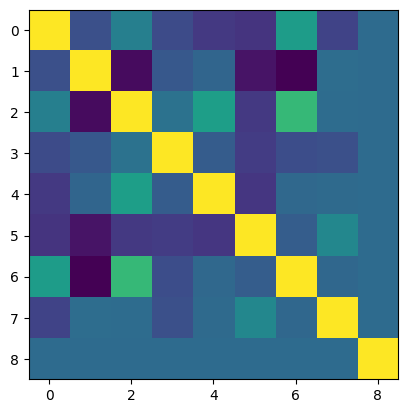

In [11]:
plt.imshow(hessian)

## Get the Hessian Eigenvalues and Eigenvectors

In [12]:
hessian = hessian.detach().numpy()
eigenvalues, eigenvectors = LA.eig(hessian)

In [13]:
eig1 = eigenvectors[:, 0]
eig2 = eigenvectors[:, 1]

# Shift the eigenvectors

eig1_shifted = eig1 - eig1/2
eig2_shifted = eig2 - eig2/2

eig1_shifted = torch.tensor(eig1_shifted.reshape(1, -1), dtype=torch.float32)
eig2_shifted = torch.tensor(eig2_shifted.reshape(1, -1), dtype=torch.float32)


## Calculate the Loss Landscape

In [14]:
# Loss Landscape Hyperparameters

n_steps = 20

step_increment = 1/n_steps

loss_landscape = []

for i in range(n_steps):
  row = []

  for j in range(n_steps):
    model.linear.weight.data = model.linear.weight.data + step_increment*j*eig1_shifted[:, :-1]
    model.linear.bias.data = model.linear.bias.data + step_increment*j*eig1_shifted[:, -1]

    loss = criterion(model(X_test_tensor), y_test_tensor)
    row.append(loss.item())
  loss_landscape.append(row)

  model.linear.weight.data = model.linear.weight.data - eig1_shifted[:, :-1]
  model.linear.bias.data = model.linear.bias.data - eig1_shifted[:, -1]

  model.linear.weight.data = model.linear.weight.data + step_increment*i*eig2_shifted[:, :-1]
  model.linear.bias.data = model.linear.bias.data + step_increment*i*eig2_shifted[:, -1]


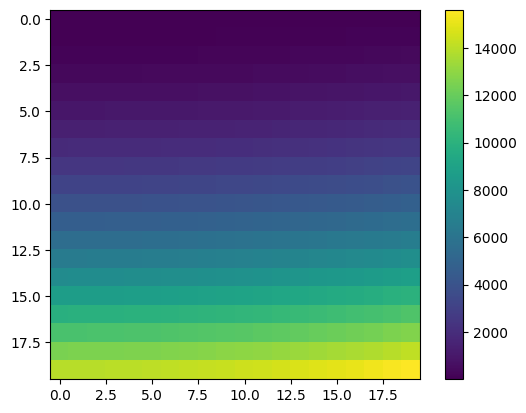

In [15]:
plt.imshow(loss_landscape)
plt.colorbar()